# Measuring model performance with and without reward shaping

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import os
import sys
import random
import numpy as np
from time import sleep
from typing import List
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.join(os.path.pardir, 'src')))

from topp import Agent
from env import GoEnv

Benchmarking Concept Function agents: 100%|██████████| 6/6 [02:20<00:00, 23.45s/it]


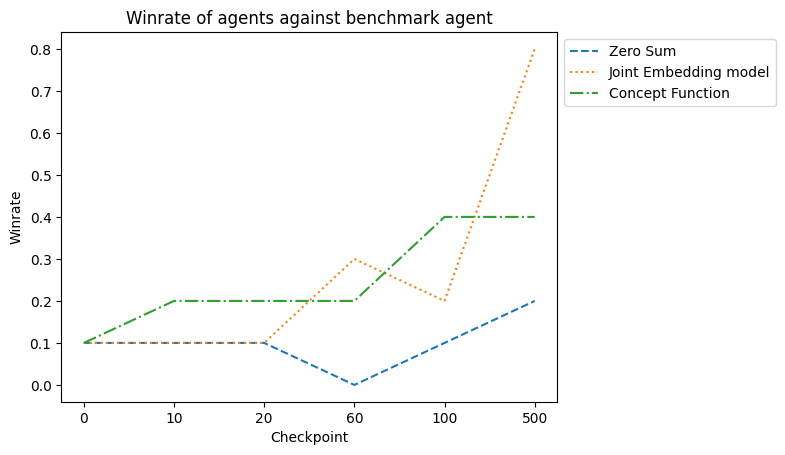

In [22]:
board_size = 7
komi = 4.5 if board_size == 7 else 1.5
move_cap = 120 if board_size == 7 else 100
num_games = 10
resnet = True
greedy_move = False

benchmark_model_path = "../models/reward_shaping/benchmark/"

model_path_zero_sum = "../models/reward_shaping/zero_sum/"
model_path_jem = "../models/reward_shaping/jem/"
model_path_concept_fn = "../models/reward_shaping/concept_fn/"

model_paths = [model_path_zero_sum, model_path_jem, model_path_concept_fn]

zero_sum_agents = []
jem_agents = []
concept_fn_agents = []

def add_agents(model_path):
    agents = []
    files = os.listdir(model_path)

    # Sort the folders by the number in the name
    sorted_files = sorted(files, key=lambda x: int(
        x.split('_')[-1].strip('.keras')))
    # Add the agents
    for file in sorted_files:
        agents.append(Agent(board_size, model_path,
                      file, greedy_move, resnet=resnet))

    if len(agents) == 0:
        raise Exception("No agents found")

    return agents


def play_game(agent, benchmark_agent, num_games, board_size, komi, move_cap):
    # Starting agent plays as black
    starting_agent: Agent = random.choice([agent, benchmark_agent])

    # Play the games
    for _ in range(num_games):
        # Create the environment
        go_env = GoEnv(size=board_size, komi=komi)
        # Reset the environment
        go_env.reset()
        current_player = 0
        # Track the number of times as black and white
        # Starting player is black
        if starting_agent == agent:
            agent.player_black += 1
            benchmark_agent.player_white += 1
        else:
            benchmark_agent.player_black += 1
            agent.player_white += 1

        current_agent = starting_agent

        # Play a random game
        terminated = False
        moves = 0
        prev_turn_state = np.zeros((board_size, board_size))
        temp_prev_turn_state = np.zeros((board_size, board_size))
        prev_opposing_state = np.zeros((board_size, board_size))

        # Play a game until termination
        while not terminated:
            curr_state = go_env.canonical_state()
            valid_moves = go_env.valid_moves()
            if current_player == 0:
                state = np.array([curr_state[0], prev_turn_state, curr_state[1], prev_opposing_state, np.zeros((board_size, board_size))])
            else:
                state = np.array([curr_state[0], prev_turn_state, curr_state[1], prev_opposing_state, np.ones((board_size, board_size))])
            if moves > move_cap:
                print("Move cap reached in game between {} and {}, termination game!".format(agent.name, benchmark_agent.name))
                sleep(1)
                break

            action, _ = current_agent.choose_action(state, valid_moves)

            _, _, terminated, _ = go_env.step(action)
            moves += 1

            if current_agent == agent:
                current_agent = benchmark_agent
            else:
                current_agent = agent
            current_player = 1 - current_player
            # Update the previous state
            prev_turn_state = temp_prev_turn_state
            prev_opposing_state = curr_state[0]
            temp_prev_turn_state = prev_opposing_state
        # Winner in perspective of the starting agent, 1 if won, -1 if lost, 0 if draw
        winner = go_env.winner()

        # Add the score
        if starting_agent == agent and winner == 1:
            agent.add_win(1)
            benchmark_agent.add_loss(2)
        elif starting_agent == agent and winner == -1:
            agent.add_loss(1)
            benchmark_agent.add_win(2)
        elif starting_agent == benchmark_agent and winner == 1:
            benchmark_agent.add_win(1)
            agent.add_loss(2)
        elif starting_agent == benchmark_agent and winner == -1:
            benchmark_agent.add_loss(1)
            agent.add_win(2)

        # Swap the starting agent
        if starting_agent == agent:
            starting_agent = benchmark_agent
        else:
            starting_agent = agent

# Plot the results for the agents against the benchmark agent
def plot_results(zero_sum_agents: List[Agent], jem_agents: List[Agent], concept_fn_agents: List[Agent]):

    # Find the agent number 
    agent_number = [int(agent.name.split('_')[-1].strip('.keras')) for agent in zero_sum_agents]
    
    # Calgulate the winrate for each agent
    winrate_zero = [agent.win / (agent.win + agent.loss) for agent in zero_sum_agents]
    winrate_jem = [agent.win / (agent.win + agent.loss) for agent in jem_agents]
    winrate_concept_fn = [agent.win / (agent.win + agent.loss) for agent in concept_fn_agents]
    

    plt.plot(winrate_zero, label="Zero Sum", linestyle='dashed')
    plt.plot(winrate_jem, label="Joint Embedding model", linestyle='dotted')
    plt.plot(winrate_concept_fn, label="Concept Function", linestyle='dashdot')
    plt.xticks(range(len(agent_number)), agent_number)
    plt.title("Winrate of agents against benchmark agent")
    plt.xlabel("Checkpoint")
    plt.ylabel("Winrate")
    # Place the legend outside the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

benchmark_agent = Agent(board_size, benchmark_model_path, 'benchmark.keras', greedy_move, resnet=resnet)

for model_path in model_paths:
    agents = add_agents(model_path)
    if model_path == model_path_zero_sum:
        zero_sum_agents = agents
    elif model_path == model_path_jem:
        jem_agents = agents
    elif model_path == model_path_concept_fn:
        concept_fn_agents = agents

for agent in tqdm(zero_sum_agents, desc="Benchmarking Zero Sum agents"):
    play_game(agent, benchmark_agent, num_games, board_size, komi, move_cap)

for agent in tqdm(jem_agents, desc="Benchmarking Joint Embedding Model agents"):
    play_game(agent, benchmark_agent, num_games, board_size, komi, move_cap)

for agent in tqdm(concept_fn_agents, desc="Benchmarking Concept Function agents"):
    play_game(agent, benchmark_agent, num_games, board_size, komi, move_cap)

plot_results(zero_sum_agents, jem_agents, concept_fn_agents)